In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    """Führt repeated k-fold cross-validation durch und berechnet die Metriken."""
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


standardabweichungen und konfuionsmatrizen in äußerer CV ergänzen!! zudem die features ausgeben lassen!

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Laden der Daten
def load_data(file_path):
    df = pd.read_excel(file_path)
    X = df.drop(columns=["Verletzungsstatus"])
    y = df["Verletzungsstatus"]
    return X, y

# Vorverarbeitung der Daten
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

# Auswahl an nicht hochkorrelierten Features herstellen
def calculate_feature_selection(X_train, y_train, correlation_threshold=0.7):
    # Berechnungen für Feature Selektion
    correlation_matrix = X_train.corr()
    mutual_info = mutual_info_classif(X_train, y_train)
    
    # ausgewählte Features
    selected_features = list(X_train.columns)  # Beginne mit allen Features
    
    # Iteriere über alle Feature-Paare
    for col in X_train.columns:
        if col in selected_features:
            # Suche nach anderen hochkorrelierten Features
            correlated_features = correlation_matrix[col].loc[correlation_matrix[col] > correlation_threshold].index.tolist()
            correlated_features.remove(col)  # Entferne das aktuelle Feature selbst
            
            if correlated_features:
                # Wenn es hochkorrelierte Features gibt, wähle das mit der höchsten Mutual Information
                for correlated_feature in correlated_features:
                    if mutual_info[X_train.columns.get_loc(col)] < mutual_info[X_train.columns.get_loc(correlated_feature)]:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if col in selected_features:
                            selected_features.remove(col)
                    else:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if correlated_feature in selected_features:
                            selected_features.remove(correlated_feature)
    
    return selected_features


# Optuna-Optimierung für äußere CV mit durchschnittlicher Anzahl an Features aus der inneren CV als Zielwert
def optimize_feature_selection(X_train, y_train, target_num_features):
    # Zuerst die nicht hochkorrelierten Features bestimmen
    candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.7)
    # Stelle sicher, dass target_num_features nicht größer als die Anzahl der Kandidaten ist:
    target_num_features = min(target_num_features, len(candidate_features))
    
    def objective(trial):
        # Der Suchraum orientiert sich an target_num_features, aber es darf nicht mehr als die
        # vorhandenen Kandidatenfeatures ausgewählt werden.
        num_features = trial.suggest_int(
            "num_features",
            max(5, target_num_features-5),
            min(len(candidate_features), target_num_features+5)
        )
        
        # Falls num_features größer als die Anzahl der Kandidatenfeatures sein könnte, beschränke sie
        num_features = min(num_features, len(candidate_features))
        
        # Auswahl der ersten num_features aus dem Kandidatenpool
        X_train_optimized = X_train[candidate_features[:num_features]]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_train_optimized, y_train, cv=5, scoring="roc_auc").mean()
        return score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    return study.best_trial


# komplette innere CV mit Berechnung der duchschnittlichen Anzahl an Features als Ausgabe
def inner_cv_feature_selection(X_train, y_train):
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    best_num_features = []

    for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
        y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

        # Features ohne hohe Korrelation zur Auswahl für Optuna
        candidate_features = calculate_feature_selection(X_inner_train, y_inner_train, correlation_threshold=0.7)

        # Achte darauf, dass der Kandidatenpool nicht leer ist und mindestens eine Feature enthält:
        if len(candidate_features) == 0:
            candidate_features = list(X_inner_train.columns)
    
        # Optuna für jedes innere Fold
        def objective(trial):
            num_features = trial.suggest_int("num_features", 5, 50)
            selected_features = X_inner_train.columns[:num_features]
            X_selected = X_inner_train[selected_features]

            model = LogisticRegression(max_iter=1000)
            score = cross_val_score(model, X_selected, y_inner_train, cv=5, scoring="roc_auc").mean()
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100)
        
        best_num_features.append(study.best_trial.params["num_features"])  # Speichere bestes Feature-Set
        
    return int(np.mean(best_num_features)) # Durchschnittliche Feature-Anzahl 


# Funktion für äußere Cross-Validation mit Feature-Optimierung über Optuna
def cross_validate(X, y):
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    results = []

    for outer_train_idx, outer_test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]


        # Innere Cross-Validation zur Berechnung der durchschnittlichen Anzahl an Features
        avg_selected_features = inner_cv_feature_selection(X_train, y_train)

        # Optuna-Optimierung in der äußeren CV, basierend auf der durchschnittlichen Anzahl der Features
        trial = optimize_feature_selection(X_train, y_train, avg_selected_features)
        num_features_optimized = trial.params['num_features']
        X_train_optimized = X_train[X_train.columns[:num_features_optimized]]

        # Logistische Regression auf den selektierten Features
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_optimized, y_train)
        
        # Ergebnisse für den aktuellen Fold der äußeren CV
        y_train_pred = model.predict(X_train_optimized)
        y_test_pred = model.predict(X_test[X_test.columns[:num_features_optimized]])

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test[X_test.columns[:num_features_optimized]])[:, 1])

        results.append({
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'F1-Score': f1,
            'Recall': recall,
            'ROC-AUC': roc_auc,
            'Num Features': num_features_optimized,
        })

    return pd.DataFrame(results)

def main(file_path):
    X, y = load_data(file_path)
    X_scaled = preprocess_data(X)

    # Durchführung der äußeren Cross-Validation und Ausgabe der Ergebnisse
    results_df = cross_validate(X_scaled, y)
    
    # Ausgabe der Ergebnisse
    print("\nErgebnisse der äußeren Cross-Validation:")
    print(results_df)
    
    # Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df.drop(columns=['Num Features']), orient="h")
    plt.xlabel("Score")
    plt.title("Modellvergleich anhand der Evaluierungsmetriken")
    plt.show()

# Pfad zur Datei
file_path = r"C:\Users\michi\Documents\Basistabelle_alle_PostOP_ML.xlsx"
main(file_path)


sollte grundsätzlich funktionieren, testen!!

[I 2025-02-11 10:02:34,323] A new study created in memory with name: no-name-8bc0dda7-a89c-437d-9ac7-867b39bd6739
[I 2025-02-11 10:02:34,372] Trial 0 finished with value: 0.9353741496598639 and parameters: {'num_features': 35}. Best is trial 0 with value: 0.9353741496598639.
[I 2025-02-11 10:02:34,404] Trial 1 finished with value: 0.9359693877551021 and parameters: {'num_features': 26}. Best is trial 1 with value: 0.9359693877551021.
[I 2025-02-11 10:02:34,431] Trial 2 finished with value: 0.5606292517006802 and parameters: {'num_features': 8}. Best is trial 1 with value: 0.9359693877551021.
[I 2025-02-11 10:02:34,462] Trial 3 finished with value: 0.8683673469387756 and parameters: {'num_features': 22}. Best is trial 1 with value: 0.9359693877551021.
[I 2025-02-11 10:02:34,491] Trial 4 finished with value: 0.8446428571428571 and parameters: {'num_features': 12}. Best is trial 1 with value: 0.9359693877551021.
[I 2025-02-11 10:02:34,524] Trial 5 finished with value: 0.9159013605442177 a


Ergebnisse der äußeren Cross-Validation:
    Train Accuracy  Test Accuracy  F1-Score    Recall   ROC-AUC  Num Features
0         1.000000       0.782609  0.782609  0.692308  0.900000            34
1         0.966667       0.782609  0.800000  0.833333  0.901515            30
2         0.977778       0.826087  0.846154  0.916667  0.954545            34
3         0.978022       1.000000  1.000000  1.000000  1.000000            34
4         0.978022       0.863636  0.869565  0.833333  0.975000            32
5         0.966667       0.782609  0.800000  0.769231  0.930769            34
6         0.988889       0.913043  0.909091  0.833333  1.000000            33
7         1.000000       0.652174  0.636364  0.583333  0.803030            38
8         0.989011       0.863636  0.880000  0.916667  0.966667            35
9         0.978022       0.863636  0.880000  0.916667  0.966667            34
10        0.977778       0.913043  0.923077  0.923077  0.984615            35
11        0.988889    

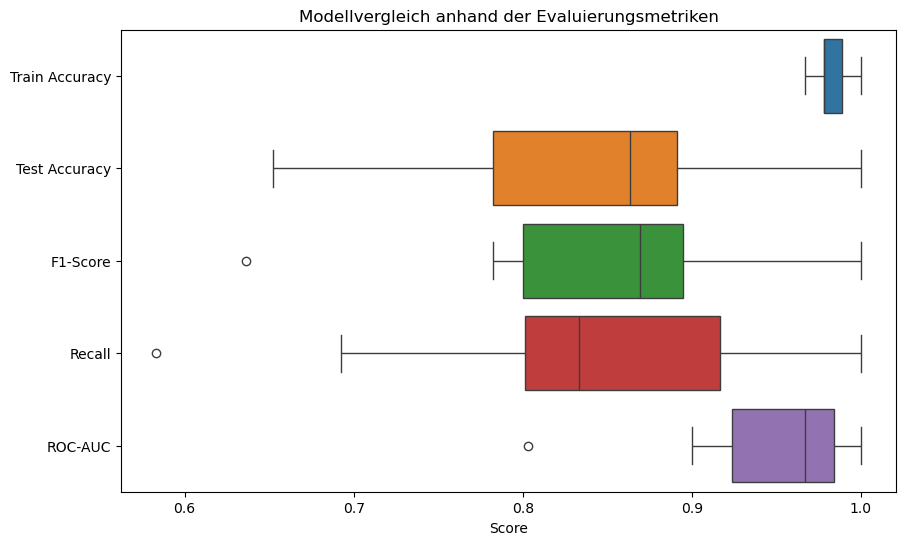

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Laden der Daten
def load_data(file_path):
    df = pd.read_excel(file_path)
    X = df.drop(columns=["Verletzungsstatus"])
    y = df["Verletzungsstatus"]
    return X, y

# Vorverarbeitung der Daten
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

# Auswahl an nicht hochkorrelierten Features herstellen
def calculate_feature_selection(X_train, y_train, correlation_threshold=0.7):
    # Berechnungen für Feature Selektion
    correlation_matrix = X_train.corr()
    mutual_info = mutual_info_classif(X_train, y_train)
    
    # ausgewählte Features
    selected_features = list(X_train.columns)  # Beginne mit allen Features
    
    # Iteriere über alle Feature-Paare
    for col in X_train.columns:
        if col in selected_features:
            # Suche nach anderen hochkorrelierten Features
            correlated_features = correlation_matrix[col].loc[correlation_matrix[col] > correlation_threshold].index.tolist()
            correlated_features.remove(col)  # Entferne das aktuelle Feature selbst
            
            if correlated_features:
                # Wenn es hochkorrelierte Features gibt, wähle das mit der höchsten Mutual Information
                for correlated_feature in correlated_features:
                    if mutual_info[X_train.columns.get_loc(col)] < mutual_info[X_train.columns.get_loc(correlated_feature)]:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if col in selected_features:
                            selected_features.remove(col)
                    else:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if correlated_feature in selected_features:
                            selected_features.remove(correlated_feature)
    
    return selected_features


# Optuna-Optimierung für äußere CV mit durchschnittlicher Anzahl an Features aus der inneren CV als Zielwert
def optimize_feature_selection(X_train, y_train, target_num_features):
    # Zuerst die nicht hochkorrelierten Features bestimmen
    candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.7)
    candidate_features = sorted(candidate_features)
    # Stelle sicher, dass target_num_features nicht größer als die Anzahl der Kandidaten ist:
    target_num_features = min(target_num_features, len(candidate_features))
    
    def objective(trial):
        # Der Suchraum orientiert sich an target_num_features, aber es darf nicht mehr als die
        # vorhandenen Kandidatenfeatures ausgewählt werden.
        num_features = trial.suggest_int(
            "num_features",
            max(5, target_num_features-5),
            min(len(candidate_features), target_num_features+5)
        )
        
        # Falls num_features größer als die Anzahl der Kandidatenfeatures sein könnte, beschränke sie
        num_features = min(num_features, len(candidate_features))
        
        # Auswahl der ersten num_features aus dem Kandidatenpool
        X_train_optimized = X_train[candidate_features[:num_features]]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_train_optimized, y_train, cv=5, scoring="roc_auc").mean()
        return score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, jobs=-1)
    return study.best_trial


# komplette innere CV mit Berechnung der duchschnittlichen Anzahl an Features als Ausgabe
def inner_cv_feature_selection(X_train, y_train):
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    best_num_features = []

    for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
        y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

        # Berechne den Kandidatenpool
        candidate_features = calculate_feature_selection(X_inner_train, y_inner_train, correlation_threshold=0.7)
        candidate_features = sorted(candidate_features)
        
        # Achte darauf, dass der Kandidatenpool nicht leer ist und mindestens eine Feature enthält:
        if len(candidate_features) == 0:
            candidate_features = list(X_inner_train.columns)
        
        def objective(trial):
            # Setze die Grenzen im Suchraum basierend auf der Länge des Kandidatenpools
            low_bound = 1 
            high_bound = len(candidate_features)
            num_features = trial.suggest_int("num_features", low_bound, high_bound)
            X_selected = X_inner_train[candidate_features[:num_features]]

            model = LogisticRegression(max_iter=1000)
            score = cross_val_score(model, X_selected, y_inner_train, cv=5, scoring="roc_auc").mean()
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100, n_jobs=-1)
        best_num_features.append(study.best_trial.params["num_features"])
        
    return int(np.mean(best_num_features))

# Funktion für äußere Cross-Validation mit Feature-Optimierung über Optuna
def cross_validate(X, y):
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    results = []

    for outer_train_idx, outer_test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]


        # Innere Cross-Validation zur Berechnung der durchschnittlichen Anzahl an Features
        avg_selected_features = inner_cv_feature_selection(X_train, y_train)

        # Optuna-Optimierung in der äußeren CV, basierend auf der durchschnittlichen Anzahl der Features
        candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.7)
        candidate_features = sorted(candidate_features)
        trial = optimize_feature_selection(X_train[candidate_features], y_train, avg_selected_features)
        num_features_optimized = trial.params['num_features']
        X_train_optimized = X_train[candidate_features[:num_features_optimized]]
        X_test_optimized = X_test[candidate_features[:num_features_optimized]]

        # Logistische Regression auf den selektierten Features
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_optimized, y_train)
        
        # Ergebnisse für den aktuellen Fold der äußeren CV
        y_train_pred = model.predict(X_train_optimized)
        y_test_pred = model.predict(X_test_optimized)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_optimized)[:, 1])

        results.append({
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'F1-Score': f1,
            'Recall': recall,
            'ROC-AUC': roc_auc,
            'Num Features': num_features_optimized,
        })

    return pd.DataFrame(results)

def main(file_path):
    X, y = load_data(file_path)
    X_scaled = preprocess_data(X)

    # Durchführung der äußeren Cross-Validation und Ausgabe der Ergebnisse
    results_df = cross_validate(X_scaled, y)
    
    # Ausgabe der Ergebnisse
    print("\nErgebnisse der äußeren Cross-Validation:")
    print(results_df)
    
    # Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df.drop(columns=['Num Features']), orient="h")
    plt.xlabel("Score")
    plt.title("Modellvergleich anhand der Evaluierungsmetriken")
    plt.show()

# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML.xlsx"
main(file_path)



Ergebnisse der äußeren Cross-Validation (aggregiert):


,Gruppe,Train Accuracy,Test Accuracy,F1 Score,Recall,ROC-AUC,Anzahl-Features
0,Total,98.38 ± 0.98,-,-,-,94.85 ± 4.40,34.07 ± 2.11
1,1 (Verletzte),-,85.03 ± 8.23,85.75 ± 8.41,84.74 ± 10.23,-,-



Verteilung der Evaluierungsmetriken (Boxplot):


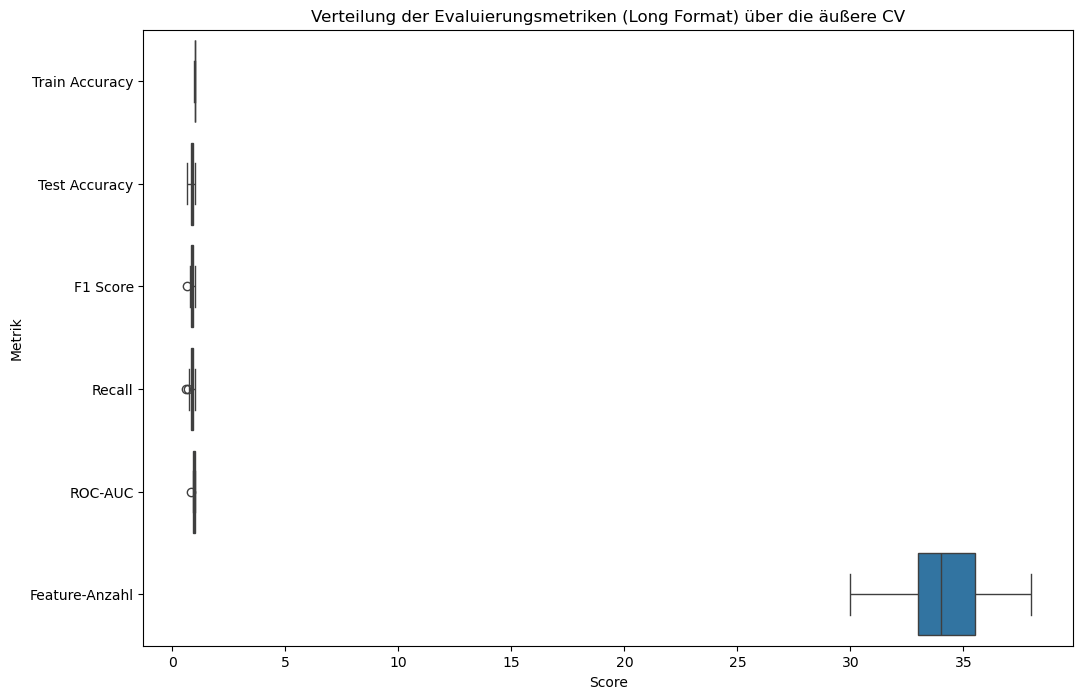

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Laden der Daten
def load_data(file_path):
    df = pd.read_excel(file_path)
    X = df.drop(columns=["Verletzungsstatus"])
    y = df["Verletzungsstatus"]
    return X, y

# Vorverarbeitung der Daten
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

# Auswahl an nicht hochkorrelierten Features herstellen
def calculate_feature_selection(X_train, y_train, correlation_threshold=0.7):
    # Berechnungen für Feature Selektion
    correlation_matrix = X_train.corr()
    mutual_info = mutual_info_classif(X_train, y_train)
    
    # ausgewählte Features
    selected_features = list(X_train.columns)  # Beginne mit allen Features
    
    # Iteriere über alle Feature-Paare
    for col in X_train.columns:
        if col in selected_features:
            # Suche nach anderen hochkorrelierten Features
            correlated_features = correlation_matrix[col].loc[correlation_matrix[col] > correlation_threshold].index.tolist()
            correlated_features.remove(col)  # Entferne das aktuelle Feature selbst
            
            if correlated_features:
                # Wenn es hochkorrelierte Features gibt, wähle das mit der höchsten Mutual Information
                for correlated_feature in correlated_features:
                    if mutual_info[X_train.columns.get_loc(col)] < mutual_info[X_train.columns.get_loc(correlated_feature)]:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if col in selected_features:
                            selected_features.remove(col)
                    else:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if correlated_feature in selected_features:
                            selected_features.remove(correlated_feature)
    
    return selected_features


# Optuna-Optimierung für äußere CV mit durchschnittlicher Anzahl an Features aus der inneren CV als Zielwert
def optimize_feature_selection(X_train, y_train, target_num_features):
    # Zuerst die nicht hochkorrelierten Features bestimmen
    candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.7)
    candidate_features = sorted(candidate_features)
    # Stelle sicher, dass target_num_features nicht größer als die Anzahl der Kandidaten ist:
    target_num_features = min(target_num_features, len(candidate_features))
    
    def objective(trial):
        # Der Suchraum orientiert sich an target_num_features, aber es darf nicht mehr als die
        # vorhandenen Kandidatenfeatures ausgewählt werden.
        num_features = trial.suggest_int(
            "num_features",
            max(5, target_num_features-5),
            min(len(candidate_features), target_num_features+5)
        )
        
        # Falls num_features größer als die Anzahl der Kandidatenfeatures sein könnte, beschränke sie
        num_features = min(num_features, len(candidate_features))
        
        # Auswahl der ersten num_features aus dem Kandidatenpool
        X_train_optimized = X_train[candidate_features[:num_features]]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_train_optimized, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
        return score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, n_jobs=-1)
    return study.best_trial


# komplette innere CV mit Berechnung der duchschnittlichen Anzahl an Features als Ausgabe
def inner_cv_feature_selection(X_train, y_train):
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    best_num_features = []

    for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
        y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

        # Berechne den Kandidatenpool
        candidate_features = calculate_feature_selection(X_inner_train, y_inner_train, correlation_threshold=0.7)
        candidate_features = sorted(candidate_features)
        
        # Achte darauf, dass der Kandidatenpool nicht leer ist und mindestens eine Feature enthält:
        if len(candidate_features) == 0:
            candidate_features = list(X_inner_train.columns)
        
        def objective(trial):
            # Setze die Grenzen im Suchraum basierend auf der Länge des Kandidatenpools
            low_bound = 1 
            high_bound = len(candidate_features)
            num_features = trial.suggest_int("num_features", low_bound, high_bound)
            X_selected = X_inner_train[candidate_features[:num_features]]

            model = LogisticRegression(max_iter=1000)
            score = cross_val_score(model, X_selected, y_inner_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100, n_jobs=-1)
        best_num_features.append(study.best_trial.params["num_features"])
        
    return int(np.median(best_num_features))

def cross_validate(X, y):
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    
    # Listen zum Sammeln der Metriken
    train_accuracies = []
    test_accuracies = []
    f1_scores = []
    recall_scores = []
    roc_auc_scores = []
    num_features = []
    
    for outer_train_idx, outer_test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        # Innere Cross-Validation zur Berechnung der durchschnittlichen Anzahl an Features
        avg_selected_features = inner_cv_feature_selection(X_train, y_train)

        # Optuna-Optimierung in der äußeren CV, basierend auf der durchschnittlichen Anzahl der Features
        candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.7)
        candidate_features = sorted(candidate_features)
        trial = optimize_feature_selection(X_train[candidate_features], y_train, avg_selected_features)
        num_features_optimized = trial.params['num_features']
        X_train_optimized = X_train[candidate_features[:num_features_optimized]]
        X_test_optimized = X_test[candidate_features[:num_features_optimized]]

        # Logistische Regression auf den selektierten Features
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_optimized, y_train)
        
        # Vorhersagen auf Trainings- und Testdaten
        y_train_pred = model.predict(X_train_optimized)
        y_test_pred = model.predict(X_test_optimized)

        # Berechnungen der Metriken
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_optimized)[:, 1])

        # Metriken zur Sammlung hinzufügen
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)
        roc_auc_scores.append(roc_auc)
        num_features.append(num_features_optimized)

    # Berechnung der Mittelwerte und Standardabweichungen
    results_summary = {
        'Train Accuracy': np.mean(train_accuracies),
        'Train Accuracy Std': np.std(train_accuracies),
        'Test Accuracy': np.mean(test_accuracies),
        'Test Accuracy Std': np.std(test_accuracies),
        'F1-Score_1': np.mean(f1_scores),
        'F1-Score Std': np.std(f1_scores),
        'Recall_1': np.mean(recall_scores),
        'Recall Std': np.std(recall_scores),
        'ROC-AUC_1': np.mean(roc_auc_scores),
        'ROC-AUC Std': np.std(roc_auc_scores),
        'Feature-Anzahl': np.mean(num_features),
        'Feature-Anzahl Std': np.std(num_features)
        
    }

    raw_metrics = {
        "Train Accuracies": train_accuracies,
        "Test Accuracies": test_accuracies,
        "F1 Scores": f1_scores,
        "Recall Scores": recall_scores,
        "ROC-AUC Scores": roc_auc_scores,
        "Feature-Anzahlen": num_features
    }

    # Rückgabe der zusammengefassten Ergebnisse
    return results_summary, raw_metrics


def display_results_summary(results_summary):
    # Formatierte Metriken mit ± Standardabweichung
    formatted_metrics = {
        "Gruppe": ["Total", "1 (Verletzte)"],
        "Train Accuracy": [
            f"{results_summary['Train Accuracy']*100:.2f} ± {results_summary['Train Accuracy Std']*100:.2f}",
            "-"
        ],
        "Test Accuracy": [
            f"{results_summary['Test Accuracy']*100:.2f} ± {results_summary['Test Accuracy Std']*100:.2f}",
            "-"
        ],
        "F1 Score": [
            "-",
            f"{results_summary['F1-Score_1']*100:.2f} ± {results_summary['F1-Score Std']*100:.2f}"
        ],
        "Recall": [
            "-",
            f"{results_summary['Recall_1']*100:.2f} ± {results_summary['Recall Std']*100:.2f}"
        ],
        "ROC-AUC": [
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}",
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}"
            
        ],
        "Anzahl-Features": [
            f"{results_summary['Feature-Anzahl']:.2f} ± {results_summary['Feature-Anzahl Std']:.2f}",
            "-"
        ]
    }

    # Erstellen des DataFrames
    df = pd.DataFrame(formatted_metrics)

    # Formatierung des DataFrames für HTML-Ausgabe
    styled_df = df.style.set_properties(**{"text-align": "center", "color": "black"}) \
                        .set_table_styles([{
                            "selector": "th", 
                            "props": [("font-size", "14px"), 
                                      ("background-color", "#f2f2f2"), 
                                      ("color", "black")]
                        }]) \
                        .set_caption("Durchschnittliche Evaluierungsmetriken über die äußere CV")

    display(styled_df)


def plot_raw_metrics(raw_metrics):
    # Erstellen eines DataFrames für die fünf Metriken
    metrics_df = pd.DataFrame({
        "Train Accuracy": raw_metrics["Train Accuracies"],
        "Test Accuracy": raw_metrics["Test Accuracies"],
        "F1 Score": raw_metrics["F1 Scores"],
        "Recall": raw_metrics["Recall Scores"],
        "ROC-AUC": raw_metrics["ROC-AUC Scores"]
    })
    
    # Umwandlung in das Long-Format (tidy data)
    metrics_long = metrics_df.melt(var_name="Metrik", value_name="Wert")
    
    # Erstellen des Boxplots für die fünf Metriken
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="Wert", y="Metrik", data=metrics_long)
    plt.xlabel("Score")
    plt.title("Verteilung der Evaluierungsmetriken über die äußere CV")
    plt.show()
    
    # Erstellen eines separaten DataFrames für die Feature-Anzahl
    features_df = pd.DataFrame({
        "Feature-Anzahl": raw_metrics["Feature-Anzahlen"]
    })
    
    # Erstellen eines separaten Boxplots für die Feature-Anzahl
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Feature-Anzahl", data=features_df)
    plt.xlabel("Feature-Anzahl")
    plt.title("Verteilung der Feature-Anzahlen über die äußere CV")
    plt.show()
    

def main():
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML.xlsx"
    X, y = load_data(file_path)
    X_scaled = preprocess_data(X)
    
    results_summary, raw_metrics = cross_validate(X_scaled, y)
    
    print("\nErgebnisse der äußeren Cross-Validation (aggregiert):")
    display_results_summary(results_summary)
    
    print("\nVerteilung der Evaluierungsmetriken (Boxplot):")
    plot_raw_metrics(raw_metrics)
    
if __name__ == "__main__":
    main()


